In [4]:
from manim import *

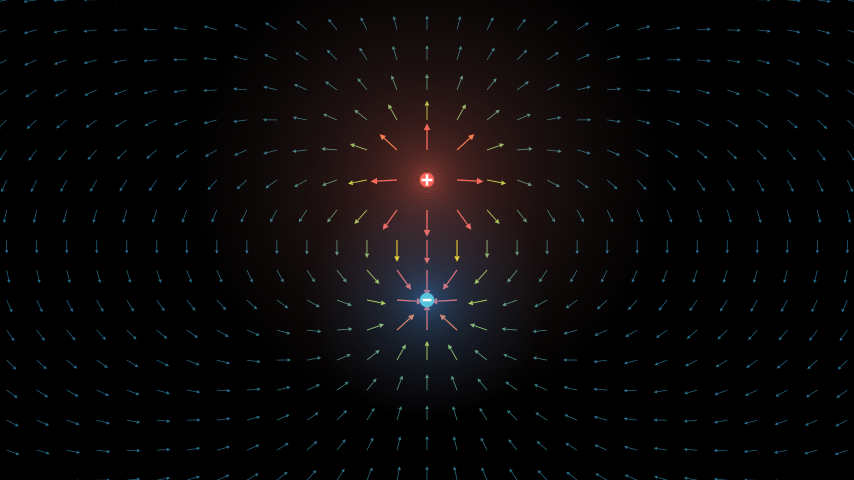

In [7]:
%%manim -ql -v WARNING ElectricFieldExampleScene

from electromagnetism import *
class ElectricFieldExampleScene(Scene):
    def construct(self):
        charge1 = Charge(1, UP)
        charge2 = Charge(-1, DOWN)
        field = ElectricField(charge1, charge2)
        self.add(charge1, charge2, field)

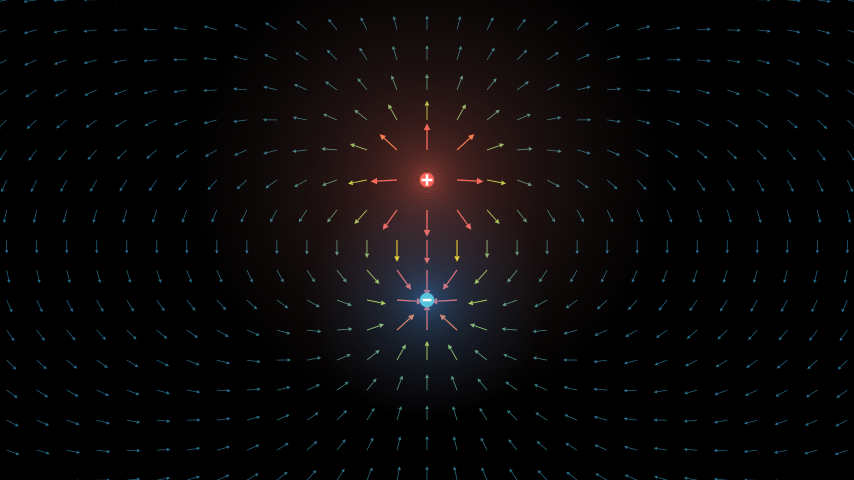

In [9]:
%%manim -ql -v WARNING ElectricFieldExampleScene

from electromagnetism import *
class ElectricFieldExampleScene(Scene):
    def construct(self):
        charge1 = Charge(1, UP)
        charge2 = Charge(-1, DOWN)
        field = ElectricField(charge1, charge2)
        self.add(charge1, charge2, field)

NameError: name 'self' is not defined